In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

sns.set(rc={'figure.figsize':(12,9)})

import matplotlib.pyplot as plt
import json


# 1 Exploratory data analysis
    The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15­minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

In [2]:
logins = pd.read_json('logins.json',keep_default_dates=True)
logins.set_index('login_time',inplace=True)

In [3]:
def change_categorical(series, cats):
    return(pd.Categorical(series, categories=cats, ordered=True))

In [4]:
logins['count'] = 1
logins = logins.resample('15T').sum()
logins['day'] = logins.index.day_name() # Convert to day of week corresponding timeindex
logins['hour'] = logins.index.hour
logins['month'] = logins.index.month_name()

/Users/krisseo/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/krisseo/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:218: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)


[Text(0.5, 0, '')]

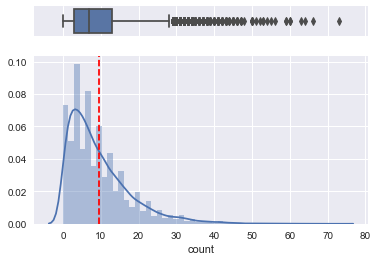

In [5]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
sns.boxplot(logins["count"], ax=ax_box)
sns.distplot(logins["count"], ax=ax_hist)
plt.axvline(logins['count'].mean(), color='r', linestyle='--') 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')

In [6]:
logins['count'].describe()

count    9788.000000
mean        9.515938
std         8.328818
min         0.000000
25%         3.000000
50%         7.000000
75%        13.000000
max        73.000000
Name: count, dtype: float64

    The distribution of logins count in 15 mintues interval is skewed right and shows there are about 9.5 logins average in 15 minutes interval

In [7]:
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday","Sunday"]
month_order = ['January','February','March','April']
logins['day'] = change_categorical(logins['day'], day_order)
logins['month'] = change_categorical(logins['month'], month_order)

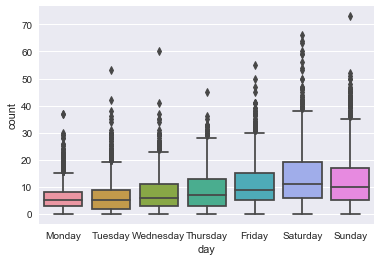

In [8]:
ax = sns.boxplot(x="day", y="count", data=logins)

Text(0, 0.5, 'count')

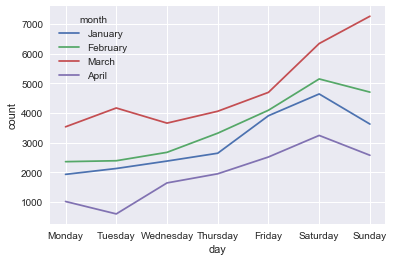

In [9]:
month_day_data = logins.groupby(['month','day'],sort=False).sum().unstack('month')['count']
month_day_data.plot()
plt.xticks(np.arange(len(day_order)),labels=day_order)
plt.ylabel('count')

    Through the boxplot of login counts based on day, people tend to log in more on weekends over weekday as our box plots' quartiles increases.
    It is more certain by looking at data grouped by month and usually Saturday has highest login counts.
    Moreover, March has the highest login counts.
    

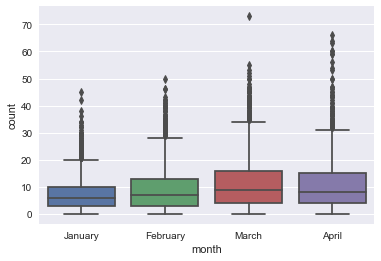

In [12]:
ax2 = sns.boxplot(x='month', y='count', data=logins, order=month_order)

    50 percentile for all months is stable and all distributions seem to be similar to each other.
    

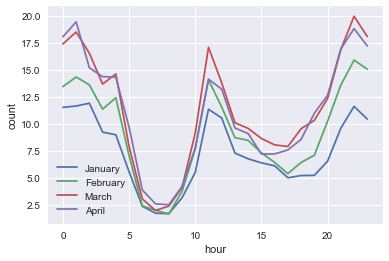

In [10]:
month_hour_data = logins.groupby(['month','hour'],sort=False).mean().unstack('month')['count']
month_hour_data.plot()
plt.ylabel('count')
plt.legend(loc='lower left')

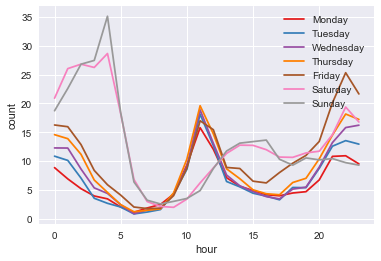

In [11]:
day_hour_data = logins.groupby(['day','hour'],sort=False).mean().unstack('day')['count']
day_hour_data.plot(colormap='Set1')
plt.ylabel('count')
plt.legend(loc='upper right')

    There are lots of users on weekends between 12:00AM and 4:00AM then users decrease till 10:00AM, which indicates most of users were in sleep after logging in.
    On the other hands, during weekdays the most active logging times are between 10:00AM and 12:00PM and 7:00PM and 11:00PM since all users will off to work for the next day. After 1:00 PM, users logging in tends to decrease due to their lunch and work hours. This life-cycle is more certain because the plot grouped by month and the plot grouped by days have similar time-cycles.
    

# 2 Experiment and metrics design
    The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities. However, a toll bridge, with a two­way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.


1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?
    

    I will choose reimbursed toll costs as the key measure of success of this experiment in encouraging driver partners to serve both cities. If driver partners are exclusive to each city and stay in one city, then reimbursed toll costs will be lower than that of driver partners serving both cities. Whenever there is more movement to each city from the other, there will be more reimbured costs to driver partners.
    Also, starting location and ending location of trip will be important to keep track of all toll costs.
    EX) if starting location == ending location --> No toll cost occured.
        if starting location != ending location --> Toll cost occured.

2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:

    a. how you will implement the experiment
    
    b. what statistical test(s) you will conduct to verify the significance of the observation
    
    c. how you would interpret the results and provide recommendations to the city 
    operations team along with any caveats.



    - a. I will randomly choose certain percentage of driver partners to reimburse their toll costs and compare their toll costs to other's.
    
    
    - b. I will conduct independent sample t-test or A/B test. Independent sample t-test compares two average toll costs in two groups and tells how significant difference occurs between two groups. 
    
    I will set a null hypothesis as these below.
    H0: There is no difference in toll costs for driver partners without and with reimubrsing toll costs.
    H1: There is a difference in toll costs for driver partners without reimbursing and with reimbursing toll costs.
   
    - c. Based on the mean and the variance of toll costs of each group, t-statistics, representing a ratio of the difference between two groups and the difference within the groups. Higher t-value will represent two groups are different,while lower t-value will represent two groups are similar.
    
    Then p-value will be calculated given a significant level of 5%. P-value represents the probability that the results will occur given null hypothesis. If p-value is less than a signficiant level, then it means the results did not occur by chance. For example, if p-value is .01, then there is only a 1% probability that a difference from an experiment happened by chance. 
    
    From p-value, we can get the critical t-values from a fixed table and compare it to calculated t-value. If the calculated t-statistic is greater than the critical t-value, the test concludes that there is a statistically significant difference between the two populations, meaning rejecting H0.
    
    I will need more information about the profit difference by encouraging drive partners to serve both cities to provie more detailed recommenations because the managers reimburse all toll costs. Generally interpreted, if the results provide there is no difference in toll costs and profits, then the city operations team should not reimburse toll costs to driver partners to save its asset. However, if we reject null hypothesis, then it indicates that driver partners are encouraged to serve both cities, which the managers wanted. Since there will be reimbursing toll costs, the managers will need to calculate how much more profit getting by providing more drive partners to both cities.
    

# 3 Predictive modeling
    Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in
    January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.
    We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.
    The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?

In [19]:
with open('ultimate_data_challenge.json') as f:
    data = json.load(f)
data = pd.DataFrame(data)
data.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [20]:
print(data.info())
print('\nNumber of missing values in the data')
print(data.isnull().sum()[data.isnull().sum()>0])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB
None

Number of missing values in the data
avg_rating_by_driver     201
avg_rating_of_driver    8122
phone                    396
dtype: int64


    201 Missing values in avg_rating_by_driver, 8122 Missing values in avg_rating_of_driver lastly 396 missing values in phone. However, missing values in avg_rating_by_driver can be caused by users only signed up and not use a service. Missing values in avg_rating_of_driver can be caused by users use a servic at first time and never use it back and users who never gives rating to driver.

## Data Manipulating and Cleaning

In [21]:
# Converting date object to dt
data.last_trip_date = pd.to_datetime(data.last_trip_date)
data.signup_date = pd.to_datetime(data.signup_date)

# Taking usage_time of users
diff = data.last_trip_date - data.signup_date
data['usage_times_in_day'] = diff.astype(pd.Timedelta).apply(lambda d: d.days)

# Taking when the data was pulled
date_pulled = max(data.last_trip_date)
cut_off_day = date_pulled - pd.Timedelta('30 days')

# Rider retention
data['active_status'] = (data.last_trip_date > cut_off_day).astype('int')


In [23]:
active_data = data[data.active_status == 1]
print('active_data is shape of ({0},{1})'.format(active_data.shape[0],active_data.shape[1]))
inactive_data = data[data.active_status == 0]
print('inactive_data is shape of ({0},{1})'.format(inactive_data.shape[0],inactive_data.shape[1]))

active_data is shape of (18310,14)
inactive_data is shape of (31690,14)


## EDA

/Users/krisseo/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


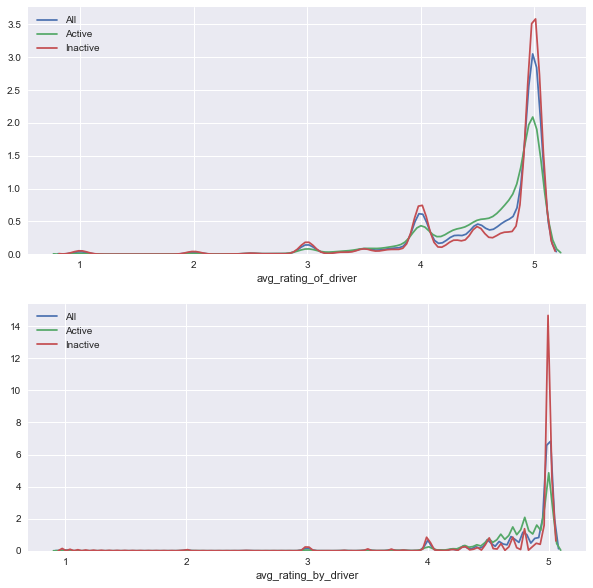

In [24]:
fig, axs = plt.subplots(2, figsize=(10,10))
sns.distplot(data.avg_rating_of_driver[data.avg_rating_of_driver.notnull()],hist=False, ax=axs[0], label='All')
sns.distplot(active_data.avg_rating_of_driver[active_data.avg_rating_of_driver.notnull()],hist=False, ax=axs[0],\
             label='Active')
sns.distplot(inactive_data.avg_rating_of_driver[inactive_data.avg_rating_of_driver.notnull()],hist=False, ax=axs[0],\
             label='Inactive')


sns.distplot(data.avg_rating_by_driver[data.avg_rating_by_driver.notnull()], hist=False, ax=axs[1], label='All')
sns.distplot(active_data.avg_rating_by_driver[active_data.avg_rating_by_driver.notnull()], hist=False, ax=axs[1], \
             label='Active')
sns.distplot(inactive_data.avg_rating_by_driver[inactive_data.avg_rating_by_driver.notnull()], hist=False, ax=axs[1],\
             label='Inactive')


    Above plots display distributions of average rating by driver and of driver and both distributions seem heavly leftly skewed. Most of the data can be explained in ratings of 4 and 5. This pattern indicates that users and drivers tend to give ratings of 4 and 5, but rarely give lower ratings to each other.
    Furthermore, the pattern appears in all situations, so the rating won't be a significant factor of predicting rider retention. 

/Users/krisseo/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


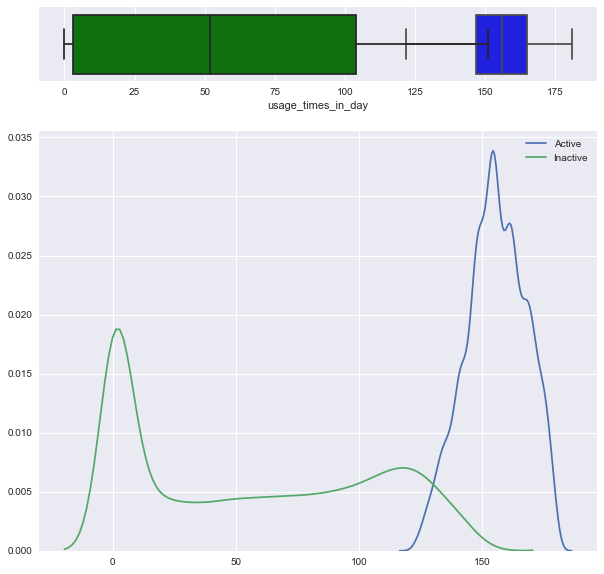

In [7]:
fig, axs = plt.subplots(2, figsize=(10,10),gridspec_kw={"height_ratios": (.15, .85)})

sns.boxplot(active_data.usage_times_in_day, ax=axs[0],color='blue')
sns.boxplot(inactive_data.usage_times_in_day, ax=axs[0], color='green')

sns.kdeplot(active_data.usage_times_in_day, label='Active', ax=axs[1])
sns.kdeplot(inactive_data.usage_times_in_day,label='Inactive', ax=axs[1])

    It is certain that inactive users' usage_times are more variant than active users.
    Active users have high usage_times. Most of inactive users population can be explained by minimum time of active users usage_time. Usage time can be a significant variable for predicting user's retention.

In [8]:
data.groupby('phone')['active_status'].value_counts()
# Android users tend to be less active than iPhone users

phone    active_status
Android  0                12080
         1                 2942
iPhone   0                19344
         1                15238
Name: active_status, dtype: int64

Text(0, 0.5, 'count')

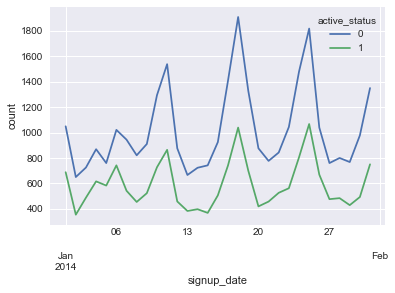

In [9]:
data.groupby('signup_date')['active_status'].value_counts().unstack().plot()
plt.ylabel('count')

    The plot displays there were three significant increases of signup for both classes.

In [10]:
def heatMap(df):
    """ Taking a dataframe and returns to Heat Map to describe 
        each of features in the df.
    """
    corr = df.corr()
    # Return Upper Triangular Correlation Matrix, since corr matrix is symmetric.
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    
    # Set Figures
    fig, ax = plt.subplots(figsize=(8, 8))
    # Generate Color Map
    colormap = sns.diverging_palette(220, 10, as_cmap=True)
    # Generate Heat Map based on Correlation
    sns.heatmap(corr, mask=mask, cmap=colormap, annot=True, fmt=".2f")
    
    # Apply xticks
    plt.xticks(range(len(corr.columns)), corr.columns);
    # Apply yticks
    plt.yticks(range(len(corr.columns)), corr.columns)
    # Show plot
    plt.show()

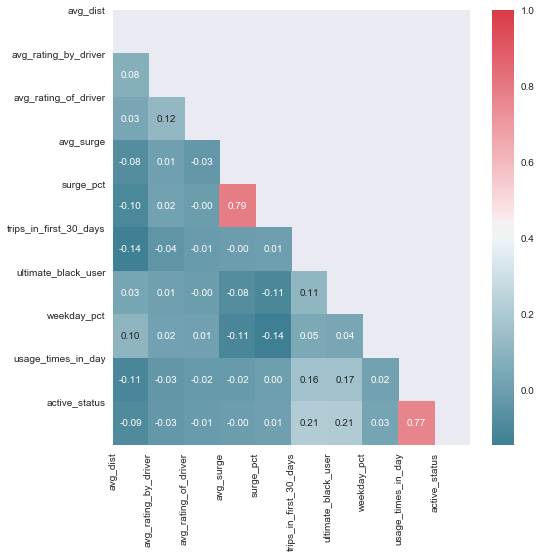

In [11]:
heatMap(data)
# As I mentioned above, there is no correlation between active_status and ratings

In [12]:
rider_retention = 100 * data.active_status.sum()/data.shape[0]
print("Rider_retention rate for January sign_up is {0}%".format(rider_retention))

Rider_retention rate for January sign_up is 36.62%


2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

    I will use logistic regression, random forest and SVM to calculate the probability of user's activity. All of them are pretty standard ML Classification and the model with the best result will be selected.

## Fill in Missing values

In [13]:
data.avg_rating_by_driver = data.avg_rating_by_driver.fillna(np.mean)
data.avg_rating_of_driver = data.avg_rating_of_driver.fillna(np.mean)
data.phone = data.phone.fillna('NaN')

## Feature Generation

In [14]:
from sklearn.preprocessing import OneHotEncoder

#interactions = data['city'] + "_" + data['phone']
cat_feature = ['city','phone']
cat_df = data[cat_feature]
cities = np.unique(cat_df.city)
phones = np.unique(cat_df.phone)

ohe = OneHotEncoder(categories=[cities,phones])
encoded = ohe.fit_transform(cat_df.values).toarray()

encoded_df = pd.DataFrame(encoded, columns=cities.tolist() + phones.tolist())

data_cols = ['trips_in_first_30_days','ultimate_black_user','usage_times_in_day','active_status']
baseline_data = data[data_cols].join(encoded_df)

In [15]:
from sklearn.model_selection import train_test_split
feature_cols = baseline_data.columns.drop('active_status')
X_train, X_test, y_train, y_test = train_test_split(baseline_data[feature_cols], baseline_data['active_status'],test_size=.2)

In [16]:
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(f_classif, k=5)

X_new = selector.fit_transform(X_train[feature_cols], y_train)
selected_features = pd.DataFrame(selector.inverse_transform(X_new), 
                                 columns=feature_cols)
# Drop features with 0 variance
selected_columns = selected_features.columns[selected_features.var() != 0]
print(selected_columns)
selected_features.head()

Index(['trips_in_first_30_days', 'usage_times_in_day', 'King's Landing',
       'Android', 'iPhone'],
      dtype='object')


,trips_in_first_30_days,ultimate_black_user,usage_times_in_day,Astapor,King's Landing,Winterfell,Android,NaN,iPhone
0,6,0,142,0,0,0,0,0,1
1,1,0,0,0,0,0,1,0,0
2,2,0,67,0,0,0,0,0,1
3,1,0,1,0,0,0,0,0,1
4,8,0,176,0,0,0,0,0,0


In [46]:
import lightgbm as lgb
from sklearn import metrics

def train_model(X_train, X_test, y_train, y_test, feature_cols=None):
    if feature_cols is None:
        feature_cols = X_train.columns.drop('active_status')
    
    train_data = lgb.Dataset(X_train[feature_cols], label=y_train)
    test_data = lgb.Dataset(X_test[feature_cols], label=y_test)
    
    param = {'num_leaves': 64, 'objective': 'binary', 
             'metric': 'auc', 'seed': 7}
    num_round = 1000
    print("Training model!")
    bst = lgb.train(param, train_data, num_round, valid_sets=[test_data], 
                    early_stopping_rounds=20, verbose_eval=False)

    y_prob = bst.predict(X_test)
    valid_score = metrics.roc_auc_score(y_test, y_prob)
    y_pred = [1 if x > .49 else 0 for x in y_prob]
    print(f"Validation AUC score: {valid_score}")
    return(y_prob,y_pred, bst)

In [47]:
y_prob, y_pred, bst = train_model(X_train[selected_columns],X_test[selected_columns], y_train,y_test,selected_columns)

Training model!
Validation AUC score: 0.9947610151522988


### Feature Importance

In [78]:
bst.best_score

defaultdict(collections.OrderedDict,
            {'valid_0': OrderedDict([('auc', 0.9947610151522988)])})

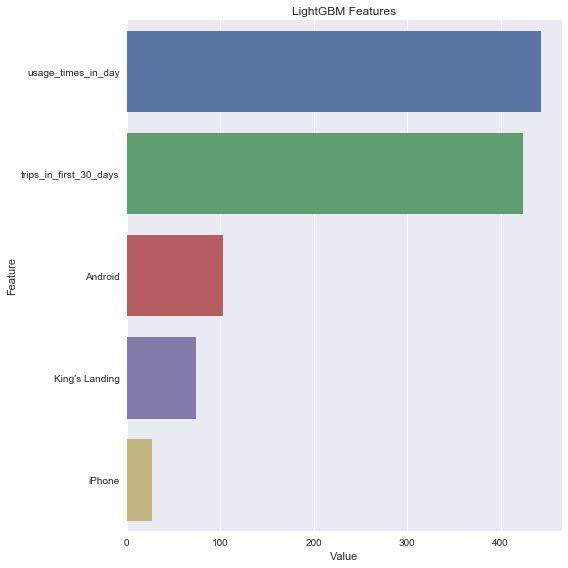

In [70]:
feature_imp = pd.DataFrame(sorted(zip(bst.feature_importance(),selected_columns)), columns=['Value','Feature'])

plt.figure(figsize=(8,8))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

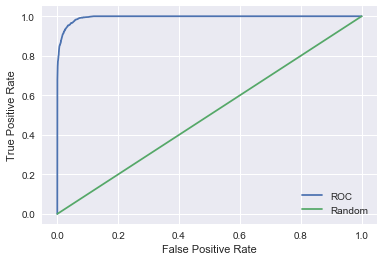

In [53]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_prob)
plt.plot(fpr,tpr,label='ROC')
plt.plot(np.linspace(0,1,500),np.linspace(0,1,500),label='Random')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
_ = plt.legend()

In [54]:
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97      6340
           1       0.93      0.96      0.94      3660

    accuracy                           0.96     10000
   macro avg       0.95      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



## Training with Random Forest

In [55]:
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(X_train[selected_columns], y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [32]:
rf_y_pred = rf.predict(X_test[selected_columns])
rf_auc_score = metrics.roc_auc_score(y_test,rf_y_pred)
rf_auc_score

0.9920788083294547

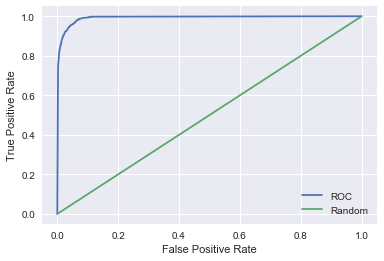

In [56]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, rf_y_pred)
plt.plot(fpr,tpr,label='ROC')
plt.plot(np.linspace(0,1,50),np.linspace(0,1,50),label='Random')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

_ = plt.legend()

3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long­term rider retention (again, a few sentences will suffice).

    Ultimate might not affect the usage time of the app, but I am sure that it can affect the trips in first_30 days by providing promotion that won't affect the company's profit. If the company provides 10% discount of first_30 days signup, there will be a jump in the usage time of the app which lead to maintain more users.